In [1]:
pip install jupyter-dash


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.7 MB/s eta 0:00:00


## Automated Sales Analytics Tool

In [2]:
from google.colab import files

# Upload the file
uploaded = files.upload()

Saving Superstore.csv to Superstore.csv


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from dash import Dash, dcc, html
from dash.dependencies import Input, Output
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import requests
import json


In [4]:
# Load the dataset
file_path = 'Superstore.csv'
df = pd.read_csv(file_path, encoding='latin1')

In [5]:
# Display the first few rows of the dataframe
print(df.head())

   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       3  CA-2016-138688   6/12/2016   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0       42420   Sout

In [6]:
# Basic information about the dataset
print("\nBasic Information:")
df.info()


Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   f

In [7]:
# Summary statistics
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
            Row ID   Postal Code         Sales     Quantity     Discount  \
count  9994.000000   9994.000000   9994.000000  9994.000000  9994.000000   
mean   4997.500000  55190.379428    229.858001     3.789574     0.156203   
std    2885.163629  32063.693350    623.245101     2.225110     0.206452   
min       1.000000   1040.000000      0.444000     1.000000     0.000000   
25%    2499.250000  23223.000000     17.280000     2.000000     0.000000   
50%    4997.500000  56430.500000     54.490000     3.000000     0.200000   
75%    7495.750000  90008.000000    209.940000     5.000000     0.200000   
max    9994.000000  99301.000000  22638.480000    14.000000     0.800000   

            Profit  
count  9994.000000  
mean     28.656896  
std     234.260108  
min   -6599.978000  
25%       1.728750  
50%       8.666500  
75%      29.364000  
max    8399.976000  


In [8]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64


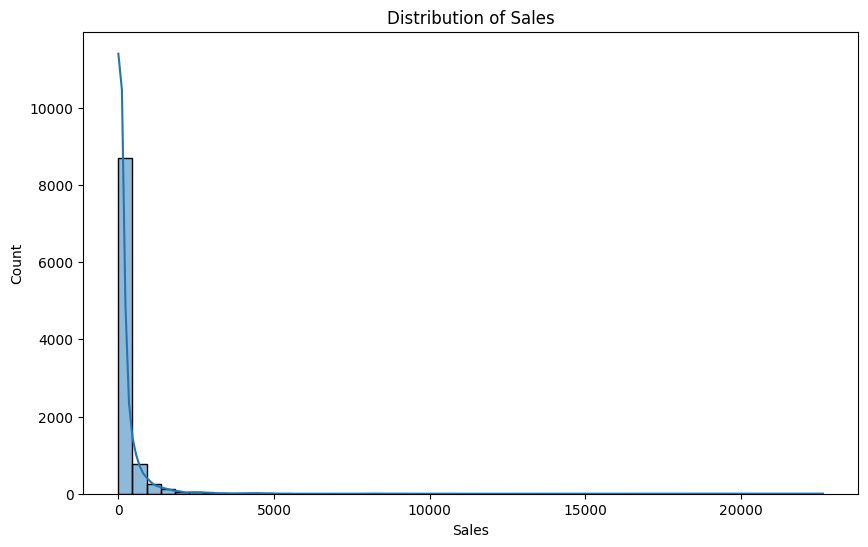

In [9]:
# Distribution of Sales
plt.figure(figsize=(10, 6))
sns.histplot(df['Sales'], bins=50, kde=True)
plt.title('Distribution of Sales')
plt.show()



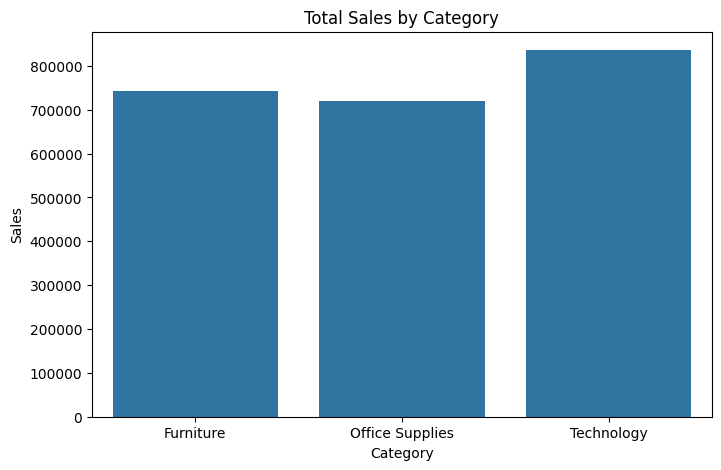

In [10]:

# Category-wise Sales
category_sales = df.groupby('Category')['Sales'].sum().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(x='Category', y='Sales', data=category_sales)
plt.title('Total Sales by Category')
plt.show()



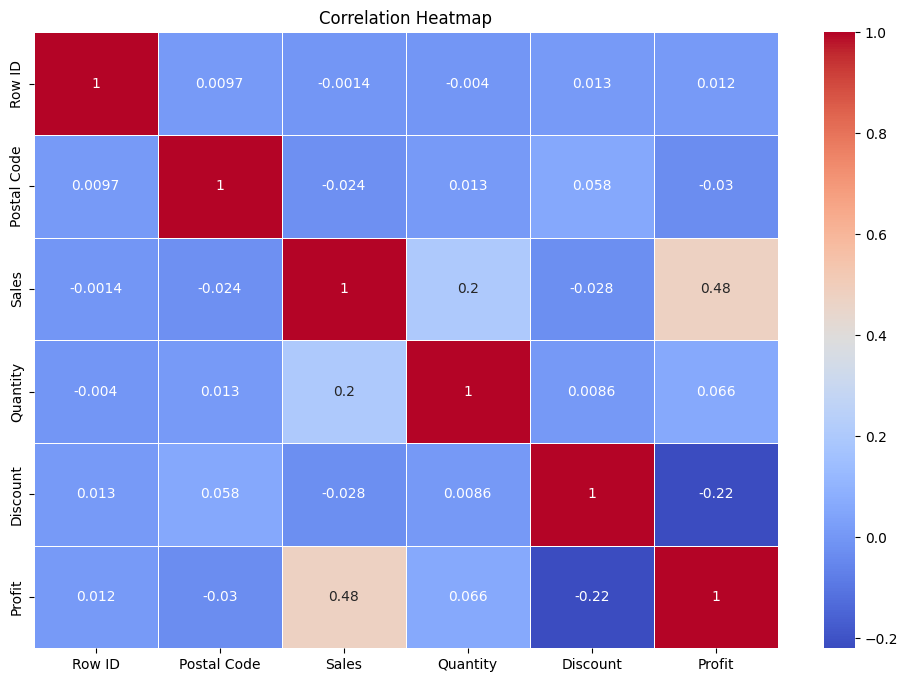

In [11]:
# Correlation Heatmap
numeric_df = df.select_dtypes(include=[float, int])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [12]:
# Clean 'Order Date' column
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df = df.dropna(subset=['Order Date'])

In [13]:
# Clean 'Sales' column
df['Sales'] = df['Sales'].replace('[\$,]', '', regex=True).astype(float)
df = df.dropna(subset=['Sales'])

In [14]:
# Initialize the Dash app
app = Dash(__name__)


In [15]:
# Define the layout
app.layout = html.Div([
    html.H1("Sales Analytics Dashboard", style={'textAlign': 'center', 'color': 'darkcyan'}),
    dcc.Dropdown(
        id='category-filter',
        options=[{'label': cat, 'value': cat} for cat in df['Category'].unique()],
        value=None,
        placeholder="Select a category",
        style={'width': '50%', 'margin': 'auto', 'padding': '10px'}
    ),
    html.Div([
        dcc.Graph(id='monthly-sales-trend', style={'width': '48%', 'marginTop': '20px'}),
        dcc.Graph(id='category-sales', style={'width': '48%', 'marginTop': '20px'}),
        dcc.Graph(id='top-products', style={'width': '48%', 'marginTop': '20px'}),
        dcc.Graph(id='region-sales', style={'width': '48%', 'marginTop': '20px'})
    ], style={'display': 'flex', 'justifyContent': 'space-around', 'flexWrap': 'wrap'})
])


In [16]:
# Callback function to update graphs based on category selection
@app.callback(
    [Output('monthly-sales-trend', 'figure'),
     Output('category-sales', 'figure'),
     Output('top-products', 'figure'),
     Output('region-sales', 'figure')],
    [Input('category-filter', 'value')]
)
def update_graphs(selected_category):
    if selected_category:
        filtered_df = df[df['Category'] == selected_category]
    else:
        filtered_df = df

    # Monthly Sales Trend
    monthly_sales = filtered_df.groupby(filtered_df['Order Date'].dt.to_period('M'))['Sales'].sum().reset_index()
    monthly_sales['Order Date'] = monthly_sales['Order Date'].astype(str)
    fig_monthly_sales = px.line(monthly_sales, x='Order Date', y='Sales', title='Monthly Sales Trend',
                                labels={'Order Date': 'Month', 'Sales': 'Total Sales'}, template='plotly_dark',
                                color_discrete_sequence=['orange'])

    # Category-wise Sales
    category_sales = filtered_df.groupby('Category')['Sales'].sum().reset_index()
    fig_category_sales = px.bar(category_sales, x='Sales', y='Category', title='Sales by Category', orientation='h',
                                labels={'Sales': 'Total Sales', 'Category': 'Product Category'}, template='plotly_dark',
                                color_discrete_sequence=['purple'])

    # Top Selling Products
    top_products = filtered_df.groupby('Product Name')['Sales'].sum().nlargest(10).reset_index()
    fig_top_products = px.bar(top_products, x='Sales', y='Product Name', title='Top 10 Selling Products', orientation='h',
                              labels={'Sales': 'Total Sales', 'Product Name': 'Product Name'}, template='plotly_dark',
                              color_discrete_sequence=['teal'])

    # Sales by Region
    region_sales = filtered_df.groupby('Region')['Sales'].sum().reset_index()
    fig_region_sales = px.bar(region_sales, x='Sales', y='Region', title='Sales by Region', orientation='h',
                              labels={'Sales': 'Total Sales', 'Region': 'Region'}, template='plotly_dark',
                              color_discrete_sequence=['crimson'])

    return fig_monthly_sales, fig_category_sales, fig_top_products, fig_region_sales


In [17]:
# Run the app
if __name__ == '__main__':
    app.run_server(port=8050, debug=False, dev_tools_ui=False, dev_tools_props_check=False)


<IPython.core.display.Javascript object>

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor  # Use DecisionTreeRegressor for regression tasks

# Prepare features and target variable
features = ['Quantity', 'Discount', 'Profit']
target = 'Sales'

X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Decision Tree Regressor': DecisionTreeRegressor()
}

# Evaluate models
for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        (name, model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f'{name} Performance:')
    print(f'RMSE: {rmse}')
    print(f'R-squared: {r2}')
    print('-' * 30)


Decision Tree Regressor Performance:
RMSE: 551.6677435107687
R-squared: 0.48478461052049193
------------------------------
